In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Load Data

Using [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/)

In [2]:
r_cols = ['userId', 'movieId', 'rating', 'unix_timestamp']

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)
ratings.head()

,userId,movieId,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


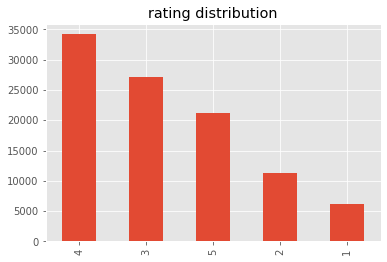

In [3]:
ratings['rating'].value_counts().plot(kind='bar');
plt.title('rating distribution');

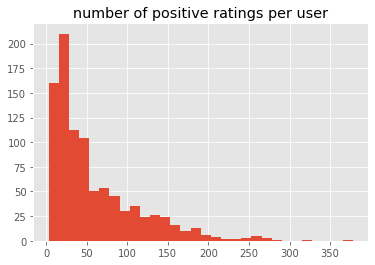

In [4]:
POSITIVE_THRESHOLD = 3.5


(ratings
.query('rating > @POSITIVE_THRESHOLD')
.groupby('userId')['rating'].count()).hist(bins='auto');
plt.title('number of positive ratings per user');

In [48]:
# select users with enought postitve marks
# this may intorduce some bias

users_test = (ratings
    .query('rating > @POSITIVE_THRESHOLD')
    .groupby('userId').size()
    .loc[lambda x: x > 65]
).index.values
print(f"number of test users: {users_test.shape}")

# select random 30 positive marks for each user
ratings_test = (ratings
[ratings['userId'].isin(users_test)]
.query('rating > @POSITIVE_THRESHOLD')
.groupby('userId').sample(30, random_state=42)
)

recommendations_test = ratings_test.groupby('userId').agg(likes=('movieId', list))
print(f"number of ratings in test set: {ratings_test.shape}")

# remove test marks from dataset
ratings_train = ratings.drop(ratings_test.index)
print(f"number of all ratings in train set: {ratings_train.shape}")
print(f"number of postitve ratings in train set: {ratings_train.query('rating > @POSITIVE_THRESHOLD').shape}")

number of test users: (305,)
number of ratings in test set: (9150, 4)
number of all ratings in train set: (90850, 4)
number of postitve ratings in train set: (46225, 4)


In [13]:
# make user/movie matrix
df = ratings_train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

nan_fraction = df.isna().sum().sum() / (df.shape[0] * df.shape[1])
print(f"dataset has {nan_fraction:2.2%} of missing values")

df = df.fillna(0)
print("uniq users: {:d}, movies: {:d}".format(*df.shape))

dataset has 94.26% of missing values
uniq users: 943, movies: 1678


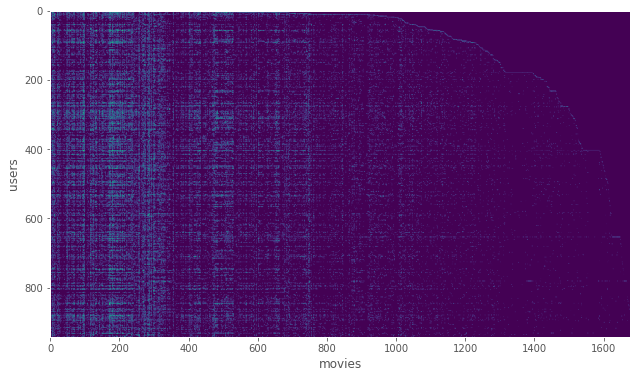

In [14]:
# sparsity visualisation
plt.figure(figsize=(12,6))
plt.xlabel('movies')
plt.ylabel('users')
plt.grid(False)
plt.imshow(df);

## Evaluation procedure

Consider 4 and 5 as positive marks, other as neagtive.  
Evaluation pipeline:

1. Remove some positive marks for some users
1. Somehow fit model on remaining data.
1. Make K recommendations for some users.
1. Calculate precision@K with removed values.


Why not simply calculate MSE between true and predicted ratings???  
Because this is not what we want from a recommender system. We don't care about how good our model is at predicting low ratings.

*Note:* It may be a good idea to split data using timestamp.

## Random Guess

Lets just **randomly sample K unseen movies**.  
It's very weak baseline, but we need it to compare with other methods.

In [67]:
K = 20
precision_at_k_list = []
for user in users_test:
    recommendations = df.loc[user].loc[lambda x: x == 0].sample(K, random_state=42).index.values
    precision = np.intersect1d(recommendations, recommendations_test.loc[user].squeeze()).shape[0] / K
    precision_at_k_list.append(precision)

mean_precision = np.mean(precision_at_k_list)
print(f"mean precision@{K} = {mean_precision:.4f}")

mean precision@20 = 0.0203


## Best movies

Sort movies by avergae ratings and recommend best unseen.  
Simple but should be better than random.

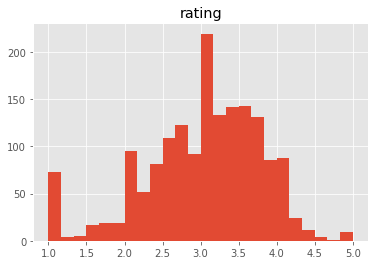

In [99]:
average_movie_rating = (ratings_train
    .groupby('movieId').agg({'rating': 'mean'})
    .sort_values('rating', ascending=False))
movieIds_sorted = average_movie_rating.index.values

average_movie_rating.hist(bins='auto');

In [85]:
user_seen_movies = (ratings_train
    .groupby('userId').agg({'movieId': list}))
    
user_seen_movies.head()

,movieId
userId,
1,"[61, 189, 33, 160, 20, 202, 171, 265, 155, 117..."
2,"[292, 251, 50, 314, 297, 290, 312, 281, 13, 28..."
3,"[335, 245, 337, 343, 323, 331, 294, 332, 328, ..."
4,"[264, 303, 361, 357, 260, 356, 294, 288, 50, 3..."
5,"[2, 17, 439, 225, 110, 454, 424, 1, 363, 98, 1..."


In [100]:
precision_at_k_list = []
for user in users_test:
    recommendations = movieIds_sorted[~np.isin(movieIds_sorted, user_seen_movies.loc[user].squeeze())][:K]

    precision = np.intersect1d(recommendations, recommendations_test.loc[user].squeeze()).shape[0] / K
    precision_at_k_list.append(precision)

mean_precision = np.mean(precision_at_k_list)
print(f"mean precision@{K} = {mean_precision:.4f}")

mean precision@20 = 0.0379


Definetely better than random, but there are obvious disadvantages:

1. No personalization at all.
2. Movie with 1 5-star mark will be recommended to everyone -- the system is very unstable.  
This could be fixed by assigning weigths based on number of ratings or by other heuristic.

## Collaborative filtering (User-based)

Basic idea:
> people, who liked this, also liked this.

Algorithm:

1. Find similar users.
2. Assign ratings to movies based on similarity scores. Users more similar to given make more impact on rating.
3. Recommend K movies with hightest predicted ratings.

How to measure similarity between users?  
In current setting users are represented as sparse vector of ratings. So, at first we need to find users, which have big intersection of movies they watched, then we can measure similarity like **correlation** or **cosine distance** etc.

## Collaborative filtering (Item-based)

Basic idea:
> movies similar to this.

The same idea as in User-based CF, but on a transposed user/item matrix.  
Define a similarity measure between items, recommend items the most similar to hight rated by user. Fairly simple.